In [1]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import PIL
from PIL import Image

In [ ]:
# Step 1: Define Paths and Split Data
base_dir = '/Users/hunte/Desktop/PetImages'
dog_dir = os.path.join(base_dir, 'Dog')
cat_dir = os.path.join(base_dir, 'Cat')

# List all files
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.endswith('.jpg')]
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.endswith('.jpg')]

# Filter out corrupt files (common in this dataset)
def is_valid_image(file):
    try:
        img = tf.keras.preprocessing.image.load_img(file)
        return True
    except:
        return False

dog_files = [f for f in dog_files if is_valid_image(f)]
cat_files = [f for f in cat_files if is_valid_image(f)]


Total Dog Images: 12501
Total Cat Images: 12501
Total Dog Files: 12500
Total Cat Files: 12500
Boo! It failed because: cannot identify image file <_io.BytesIO object at 0x0000024C0A15E250>


c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Boo! It failed because: cannot identify image file <_io.BytesIO object at 0x0000024C0A1DE570>
After filtering: 12499 dog pictures, 12499 cat pictures


In [4]:
# Split into train and validation (80-20)
dog_train, dog_val = train_test_split(dog_files, test_size=0.2, random_state=42)
cat_train, cat_val = train_test_split(cat_files, test_size=0.2, random_state=42)

train_files = dog_train + cat_train
val_files = dog_val + cat_val
train_labels = [1] * len(dog_train) + [0] * len(cat_train)  # 1=dog, 0=cat
val_labels = [1] * len(dog_val) + [0] * len(cat_val)

In [5]:
# Step 2: Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Flow from DataFrame (since files aren't in subfolders we control)
import pandas as pd
train_df = pd.DataFrame({'filename': train_files, 'class': [str(l) for l in train_labels]})
val_df = pd.DataFrame({'filename': val_files, 'class': [str(l) for l in val_labels]})

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Step 3: Build Enhanced CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Found 19998 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,112,001 (19.50 MB)

 Trainable params: 5,110,017 (19.49 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [8]:
# Step 4: Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Step 5: Train with Callback (Fixed!)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'  # Changed to .keras
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks=[checkpoint]
)

Epoch 1/20


c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


214/624 ━━━━━━━━━━━━━━━━━━━━ 51s 127ms/step - accuracy: 0.5730 - loss: 1.0999 - precision: 0.5703 - recall: 0.5724

c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 87s 138ms/step - accuracy: 0.5973 - loss: 0.9254 - precision: 0.5971 - recall: 0.5904 - val_accuracy: 0.7045 - val_loss: 0.6194 - val_precision: 0.7364 - val_recall: 0.6376
Epoch 2/20
  1/624 ━━━━━━━━━━━━━━━━━━━━ 1:11 114ms/step - accuracy: 0.7500 - loss: 0.4713 - precision: 0.8667 - recall: 0.6842

c:\Users\hunte\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7500 - loss: 0.4713 - precision: 0.8667 - recall: 0.6842 - val_accuracy: 0.7047 - val_loss: 0.6260 - val_precision: 0.7303 - val_recall: 0.6477
Epoch 3/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 87s 139ms/step - accuracy: 0.6902 - loss: 0.6056 - precision: 0.6979 - recall: 0.6816 - val_accuracy: 0.7752 - val_loss: 0.4761 - val_precision: 0.7829 - val_recall: 0.7616
Epoch 4/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7188 - loss: 0.4644 - precision: 0.7895 - recall: 0.7500 - val_accuracy: 0.7742 - val_loss: 0.4795 - val_precision: 0.7827 - val_recall: 0.7592
Epoch 5/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.7516 - loss: 0.5146 - precision: 0.7554 - recall: 0.7449 - val_accuracy: 0.8067 - val_loss: 0.4101 - val_precision: 0.7963 - val_recall: 0.8240
Epoch 6/20
624/624 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6875 - loss: 0.6810 - precision: 0.6250 - recall: 0.7143 - val_accuracy: 0.8075 - val_loss: 0.4125 

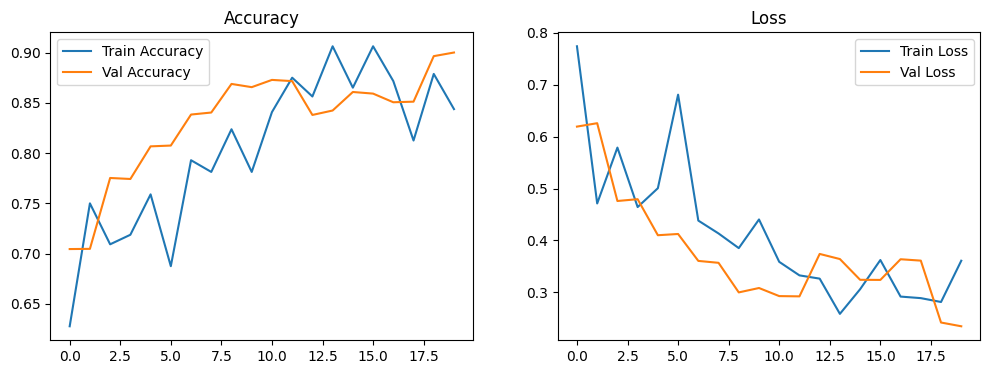

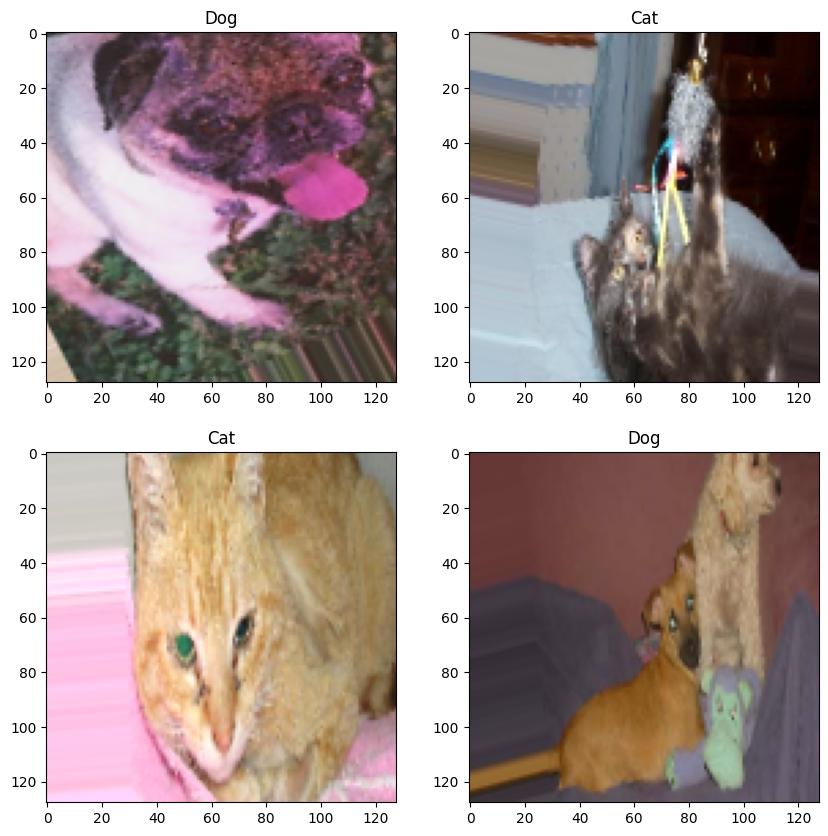

In [10]:
# Step 6: Visualize Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Bonus: Visualize Augmented Images
x, y = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(x[i])
    plt.title('Cat' if y[i] == 0 else 'Dog')
plt.show()

In [5]:
import torch

print("PyTorch version:", torch.__version__)
print("GPUs available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Number of GPUs:", torch.cuda.device_count())

PyTorch version: 2.8.0.dev20250325+cu128
GPUs available: True
GPU name: NVIDIA GeForce RTX 4070 SUPER
Number of GPUs: 1
